# Merkle Datathon - Parte III

Modelo predictivo de audiencia televisiva de la TPA con datos previos de audiencia, clima y movilidad.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
df_clima = pd.read_csv("data/datathon2023_1/pred_climaAsturias.csv", na_values=["nan", "", "Ip"])

df_clima['fecha'] = pd.to_datetime(df_clima['fecha'], format='%d/%m/%Y')
df_clima.set_index('fecha', inplace=True)

# Check for missing values
df_clima = df_clima.interpolate(method='nearest')
print(df_clima.isna().sum())


estacion_metereologica    0
temp_media                0
precipitacion             0
sol                       0
dtype: int64


In [3]:

df_audiencia = pd.read_excel("data/datathon2023_1/pred_AudienciasAsturias.xlsx")
df_audiencia['Fechas'] = pd.to_datetime(df_audiencia['Fechas'], format='%Y/%m/%d')
df_audiencia.set_index('Fechas', inplace=True)

df_audiencia = df_audiencia.interpolate(method='nearest')
print(df_audiencia.isna().sum())

df_audiencia = df_audiencia[['MAA_TTV_4plus', 'MAud_TTV_4plus', 'AM_TTV_4plus']]

Unnamed: 0          0
MAud_TTV_4plus      0
Cuota_TTV_4plus     0
AM_TTV_4plus        0
MAA_TTV_4plus       0
                   ..
MAA_Sexta_65plus    0
MAud_TPA_65plus     0
Cuota_TPA_65plus    0
AM_TPA_65plus       0
MAA_TPA_65plus      0
Length: 321, dtype: int64


In [4]:
df_movilidad = pd.read_csv("data/datathon2023_1/pred_Movilidad.csv")
df_movilidad['date'] = pd.to_datetime(df_movilidad['date'], format='%d/%m/%Y')
df_movilidad.set_index('date', inplace=True)

df_movilidad = df_movilidad.interpolate(method='nearest')
print(df_movilidad.isna().sum())

country_region_code                                   0
country_region                                        0
sub_region_1                                          0
place_id                                              0
retail_and_recreation_percent_change_from_baseline    0
grocery_and_pharmacy_percent_change_from_baseline     0
parks_percent_change_from_baseline                    0
transit_stations_percent_change_from_baseline         0
workplaces_percent_change_from_baseline               0
residential_percent_change_from_baseline              0
dtype: int64


In [5]:
# Define the columns to drop
columns_to_drop_movilidad = ['country_region_code', 'country_region', 'place_id', 'sub_region_1']
df_movilidad.drop(columns=columns_to_drop_movilidad, inplace=True)

In [6]:
# Pivot the data to have one row per date and multiple columns for each place's temperature, precipitation, and sun data
pivot_df = df_clima.pivot_table(values=['temp_media', 'precipitacion', 'sol'], index='fecha', columns='estacion_metereologica')

# Flatten the column names to remove the hierarchical index created by the pivot_table function
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

In [7]:
df_clima_movilidad = df_movilidad.join(pivot_df, rsuffix='_dummy')

# DATASET THAT WILL BE USED TO TRAIN AND TEST.
df = df_audiencia.join(df_clima_movilidad)

# DATASET THAT WILL BE USED TO MAKE THE PREDICTION
df_clima_movilidad_to_predict = df_movilidad.join(pivot_df, rsuffix='_dummy')

In [8]:
df = df.interpolate(method='nearest')
print(df.isna().sum())

MAA_TTV_4plus                                         0
MAud_TTV_4plus                                        0
AM_TTV_4plus                                          0
retail_and_recreation_percent_change_from_baseline    0
grocery_and_pharmacy_percent_change_from_baseline     0
parks_percent_change_from_baseline                    0
transit_stations_percent_change_from_baseline         0
workplaces_percent_change_from_baseline               0
residential_percent_change_from_baseline              0
precipitacion_ASTURIAS AEROPUERTO                     0
precipitacion_CABO BUSTO                              0
precipitacion_CABO PENAS                              0
precipitacion_CASTROPOL                               0
precipitacion_GIJON                                   0
precipitacion_LLANES                                  0
precipitacion_OVIEDO                                  0
precipitacion_PAJARES-VALGRANDE                       0
sol_ASTURIAS AEROPUERTO                         

In [9]:
for column in df.columns:
    print(column, end=',')

MAA_TTV_4plus,MAud_TTV_4plus,AM_TTV_4plus,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,precipitacion_ASTURIAS AEROPUERTO,precipitacion_CABO BUSTO,precipitacion_CABO PENAS,precipitacion_CASTROPOL,precipitacion_GIJON,precipitacion_LLANES,precipitacion_OVIEDO,precipitacion_PAJARES-VALGRANDE,sol_ASTURIAS AEROPUERTO,sol_CABO BUSTO,sol_CABO PENAS,sol_CASTROPOL,sol_GIJON,sol_LLANES,sol_OVIEDO,sol_PAJARES-VALGRANDE,temp_media_ASTURIAS AEROPUERTO,temp_media_CABO BUSTO,temp_media_CABO PENAS,temp_media_CASTROPOL,temp_media_GIJON,temp_media_LLANES,temp_media_OVIEDO,temp_media_PAJARES-VALGRANDE,

In [10]:
# Select the columns you want to use for training
train_columns = df.columns  # List of columns for training
pred_columns = df_clima_movilidad_to_predict.columns   # List of columns for prediction

train_columns = [col for col in df.columns if col not in ['MAA_TTV_4plus', 'MAud_TTV_4plus', 'AM_TTV_4plus']]  # exclude the target variable from the training columns
pred_columns = [col for col in df_clima_movilidad_to_predict.columns if col not in ['MAA_TTV_4plus']]  # exclude the target variable from the training columns

train_data = df

In [11]:
# Train the SARIMAX model
model = SARIMAX(train_data['MAA_TTV_4plus'], exog=train_data[train_columns], order=(0, 1, 1), seasonal_order=(0, 0, 0, 7), n_jobs = -1)
model_fit = model.fit()

C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# Prepare exogenous variables for prediction
exog_test = df_clima_movilidad_to_predict.tail(7)

# Prediction
forecast = model_fit.predict(start=len(train_data), end=len(train_data) + 6, exog=exog_test)
print(forecast)

2022-10-09    633.586043
2022-10-10    651.669776
2022-10-11    644.581506
2022-10-12    660.085645
2022-10-13    642.468846
2022-10-14    632.637543
2022-10-15    631.329973
Freq: D, Name: predicted_mean, dtype: float64


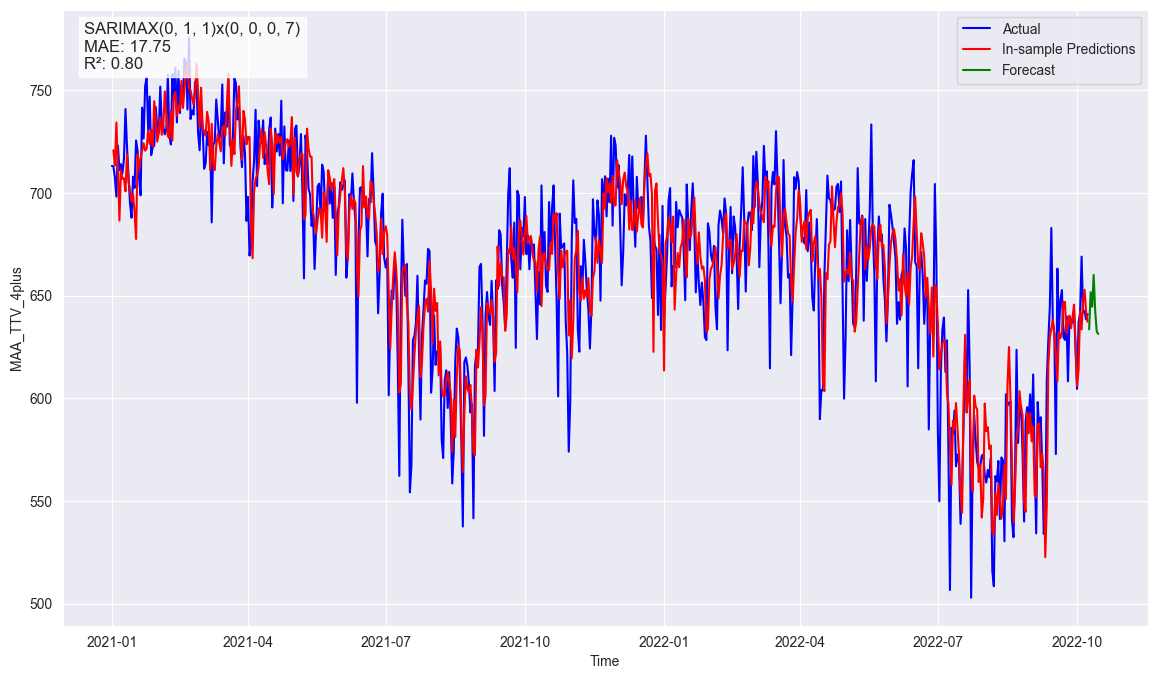

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate in-sample predictions one at a time
in_sample_preds = []
for t in range(1, len(train_data)):
    pred = model_fit.predict(start=t, end=t, exog=train_data[train_columns].iloc[t].values.reshape(1, -1))
    in_sample_preds.append(pred[0])

# Convert the list of predictions to a NumPy array
in_sample_preds = np.array(in_sample_preds)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(train_data['MAA_TTV_4plus'][1:], in_sample_preds)

# Calculate the R-squared score
r2 = r2_score(train_data['MAA_TTV_4plus'][1:], in_sample_preds)

# Set Seaborn style
sns.set_style('darkgrid')

# Create a plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the actual values
ax.plot(train_data.index, train_data['MAA_TTV_4plus'].values, label='Actual', color='blue')

# Plot the in-sample predictions
ax.plot(train_data.index[1:], in_sample_preds, label='In-sample Predictions', color='red')

# Create a new index for the forecasted values
forecast_index = pd.date_range(train_data.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')

# Plot the forecasted values
ax.plot(forecast_index, forecast.values, label='Forecast', color='green')

# Add labels and legend
ax.set_xlabel('Time')
ax.set_ylabel('MAA_TTV_4plus')
ax.legend()

# Display the MAE, R², and model information on the plot
model_info = f"SARIMAX(0, 1, 1)x(0, 0, 0, 7)\nMAE: {mae:.2f}\nR²: {r2:.2f}"
ax.text(0.02, 0.98, model_info, fontsize=12, va='top', ha='left', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()


---

# Grid Search for SARIMAX hyperparameters

In [14]:
from math import sqrt

# Define the range of hyperparameters for the grid search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 2)
P_values = range(0, 2)
D_values = range(0, 1)
Q_values = range(0, 2)
s = 7  # Seasonal frequency

# Split data into train and test sets
train_data = df.iloc[:-20]
test_data = df.iloc[-20:]

# Grid search function
def grid_search_sarimax(train_data, test_data, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_mse = float("inf")
    best_params = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                # Train the SARIMAX model
                                model = SARIMAX(train_data['MAA_TTV_4plus'], exog=train_data[train_columns],
                                                order=(p, d, q), seasonal_order=(P, D, Q, s))
                                model_fit = model.fit()
                                
                                # Prediction
                                exog_test = test_data[train_columns].copy()
                                last_known_values = train_data[train_columns].iloc[-1]
                                for column in set(train_columns) - set(pred_columns):
                                    exog_test[column] = last_known_values[column]
                                forecast = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=exog_test)
                                
                                # Calculate MSE
                                rmse = sqrt(mean_squared_error(test_data['MAA_TTV_4plus'], forecast))
                                
                                # Update best MSE and best_params
                                if rmse < best_mse:
                                    best_mse = rmse
                                    best_params = (p, d, q, P, D, Q, s)
                                    print(f"Best MSE: {best_mse}")
                                    print(f"Best hyperparameters: (p, d, q, P, D, Q, s) = {best_params}")

                                
                            except:
                                continue
    return best_mse, best_params

# Perform grid search
best_mse, best_params = grid_search_sarimax(train_data, test_data, p_values, d_values, q_values, P_values, D_values, Q_values, s)
print(f"Best MSE: {best_mse}")
print(f"Best hyperparameters: (p, d, q, P, D, Q, s) = {best_params}")


C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Best MSE: 57.583136773407496
Best hyperparameters: (p, d, q, P, D, Q, s) = (0, 0, 0, 0, 0, 0, 7)


C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qb

Best MSE: 45.08049302956302
Best hyperparameters: (p, d, q, P, D, Q, s) = (0, 0, 0, 0, 0, 1, 7)


C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Best MSE: 28.985747711031575
Best hyperparameters: (p, d, q, P, D, Q, s) = (0, 0, 0, 1, 0, 0, 7)


C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Best MSE: 21.92175411626888
Best hyperparameters: (p, d, q, P, D, Q, s) = (0, 0, 0, 1, 0, 1, 7)


C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qb

Best MSE: 14.32097457596931
Best hyperparameters: (p, d, q, P, D, Q, s) = (0, 1, 1, 0, 0, 0, 7)


C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qb

Best MSE: 14.32097457596931
Best hyperparameters: (p, d, q, P, D, Q, s) = (0, 1, 1, 0, 0, 0, 7)


C:\Users\danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


---

# Additional visualizations for Part I and II

In [15]:
import pandas as pd

# Assuming your DataFrame is called 'df'
# Replace 'Dates' and 'numeric_variable' with your specific column names
df = df.reset_index().rename(columns={'index': 'Fechas'})


In [16]:
date_column = 'Fechas'
numeric_column = 'MAA_TTV_4plus'

# Convert the 'Dates' column to pandas datetime objects
df[date_column] = pd.to_datetime(df[date_column])

# Extract the day of the week and create a new column 'day_of_week'
df['day_of_week'] = df[date_column].dt.day_name()

# Group the data by 'day_of_week' and calculate the mean of the numeric variable
mean_values = df.groupby('day_of_week')[numeric_column].mean()

# Find the day with the highest mean value
highest_day = mean_values.idxmax()

print(f"The day of the week with the highest average value for '{numeric_column}' is {highest_day}.")

The day of the week with the highest average value for 'MAA_TTV_4plus' is Tuesday.


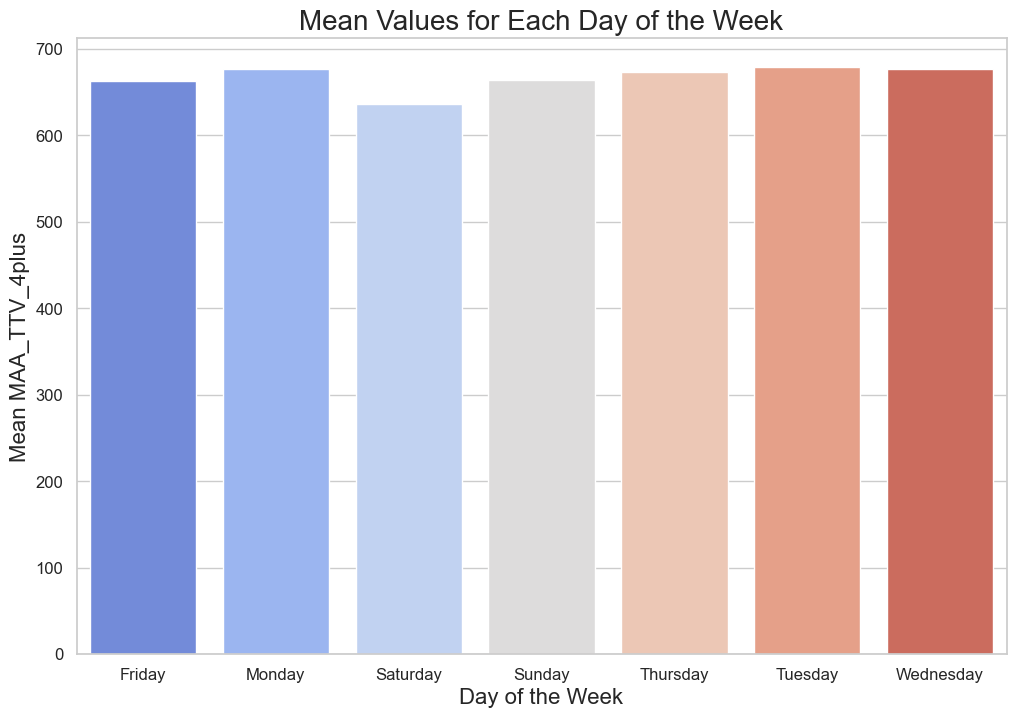

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset the index of the mean_values Series to use it as a DataFrame
mean_values_df = mean_values.reset_index()

# Create a bar plot of the mean values for each day of the week
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 8))
sns.barplot(x='day_of_week', y=numeric_column, data=mean_values_df, palette='coolwarm')

# Customize the plot
plt.title('Mean Values for Each Day of the Week', fontsize=20)
plt.xlabel('Day of the Week', fontsize=16)
plt.ylabel(f'Mean {numeric_column}', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


The day of the week with the highest average value for 'AM_TTV_4plus' is Sunday.


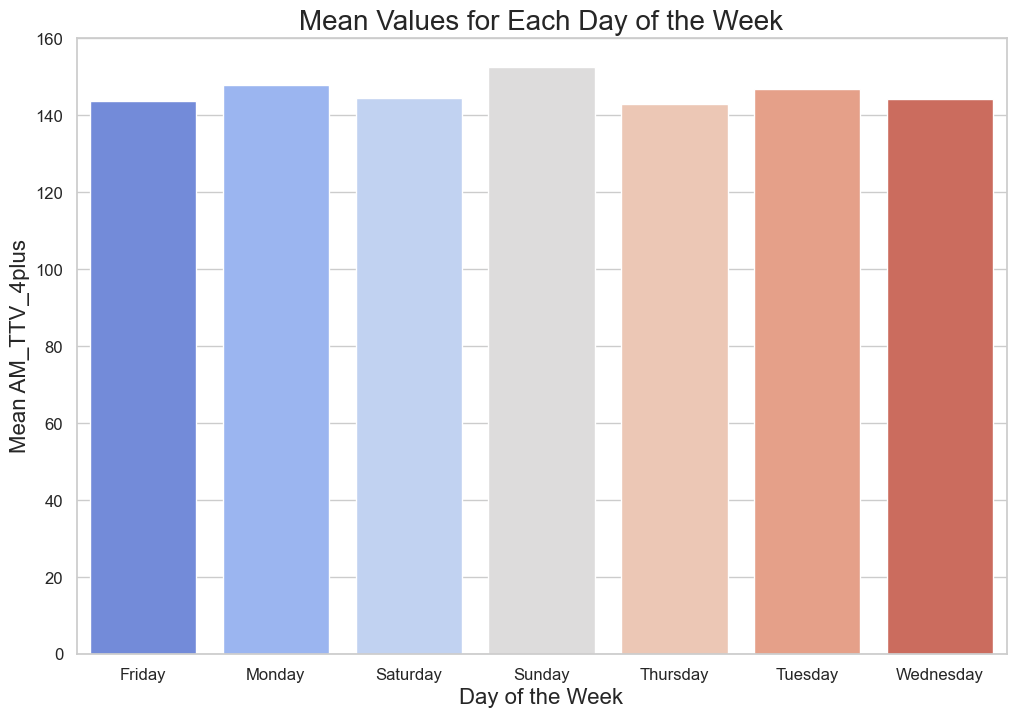

In [18]:
date_column = 'Fechas'
numeric_column = 'AM_TTV_4plus'

# Convert the 'Dates' column to pandas datetime objects
df[date_column] = pd.to_datetime(df[date_column])

# Extract the day of the week and create a new column 'day_of_week'
df['day_of_week'] = df[date_column].dt.day_name()

# Group the data by 'day_of_week' and calculate the mean of the numeric variable
mean_values = df.groupby('day_of_week')[numeric_column].mean()

# Find the day with the highest mean value
highest_day = mean_values.idxmax()

print(f"The day of the week with the highest average value for '{numeric_column}' is {highest_day}.")

import seaborn as sns
import matplotlib.pyplot as plt

# Reset the index of the mean_values Series to use it as a DataFrame
mean_values_df = mean_values.reset_index()

# Create a bar plot of the mean values for each day of the week
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 8))
sns.barplot(x='day_of_week', y=numeric_column, data=mean_values_df, palette='coolwarm')

# Customize the plot
plt.title('Mean Values for Each Day of the Week', fontsize=20)
plt.xlabel('Day of the Week', fontsize=16)
plt.ylabel(f'Mean {numeric_column}', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


In [19]:
import pandas as pd

# Assuming your DataFrame is called 'df'
# Replace 'Dates' and 'numeric_variable' with your specific column names
date_column = 'Fechas'
numeric_column = 'AM_TTV_4plus'

# Convert the 'Dates' column to pandas datetime objects
df[date_column] = pd.to_datetime(df[date_column])

# Extract the day of the week and create a new column 'day_of_week'
df['day_of_week'] = df[date_column].dt.dayofweek  # Monday=0, Sunday=6

# Calculate the correlation between the day of the week and the numeric value (number of viewers)
correlation = df['day_of_week'].corr(df[numeric_column])

print(f"The correlation between the day of the week and the number of viewers is {correlation:.4f}.")


The correlation between the day of the week and the number of viewers is 0.0315.


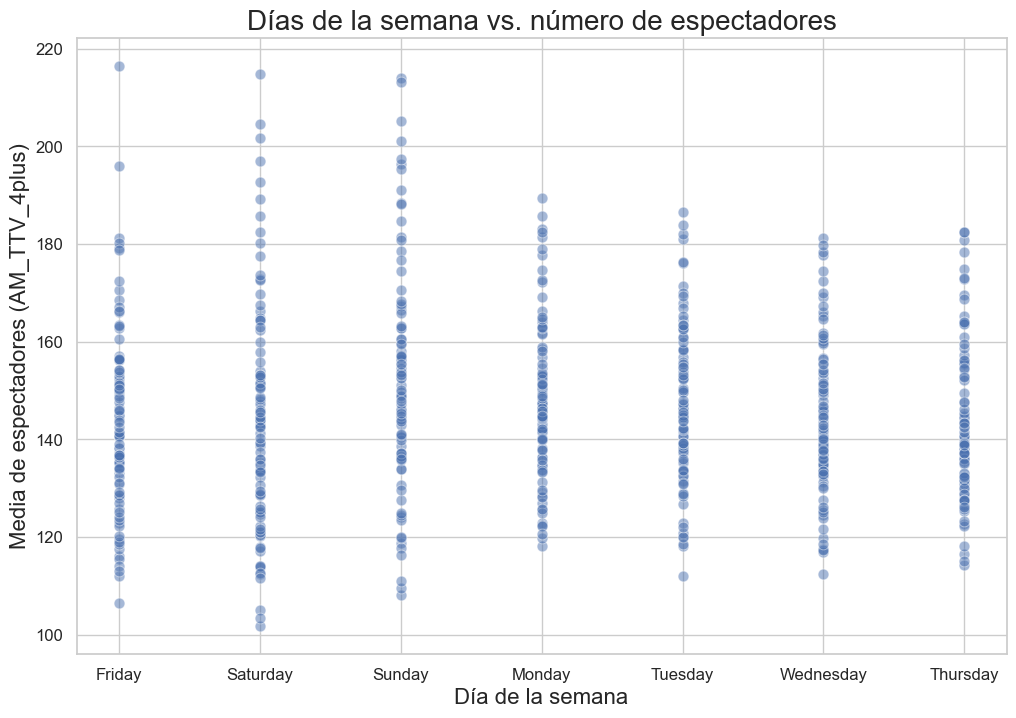

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'df'
# Replace 'Dates' and 'numeric_variable' with your specific column names
date_column = 'Fechas'
numeric_column = 'AM_TTV_4plus'

# Convert the 'Dates' column to pandas datetime objects
df[date_column] = pd.to_datetime(df[date_column])

# Extract the day of the week and create a new column 'day_of_week'
df['day_of_week'] = df[date_column].dt.day_name()

# Create a scatterplot to visualize the relationship between the day of the week and the number of viewers
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 8))
sns.scatterplot(x='day_of_week', y=numeric_column, data=df, s=60, alpha=0.5)

# Customize the plot
plt.title('Días de la semana vs. número de espectadores', fontsize=20)
plt.xlabel('Día de la semana', fontsize=16)
plt.ylabel(f'Media de espectadores ({numeric_column})', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()
